In [14]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import requests
import os
import numpy as np

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 200)

## Fetch Data

In [15]:
standings_ulrs = {
    "Serie A": "http://api.football-data.org/v4/competitions/SA/standings",
    "Bundesliga": "http://api.football-data.org/v4/competitions/BL1/standings",
    "La Liga": "http://api.football-data.org/v4/competitions/PD/standings"
}
headers = {"X-Auth-Token": os.getenv('footaball_data_token')}

### Standing

In [16]:
standings = {}

for competition, url in standings_ulrs.items():
    response = requests.get(url, headers=headers)

    data = response.json()
    data = data['standings'][0]['table']
    standing = pd.DataFrame(data)

    # Extract the 'shortName' value from the 'team' dictionary
    standing['team_short_name'] = standing['team'].apply(lambda x: x['shortName'])
    # Drop the 'team' column
    standing.drop(columns=['team'], inplace=True)
    
    n_groups = 3
    standing['team_group'] = standing.position.apply(lambda x: int(((x-1)/(20/n_groups))))
    standing['team_short_name'] = \
                standing['team_short_name']\
                        .replace({
                        'Spezia Calcio':'Spezia',
                        #
                        'Frankfurt':'Ein Frankfurt', 
                        '1. FC Köln': 'FC Koln',
                        'Hertha BSC': 'Hertha', 
                        'Bremen': 'Werder Bremen', 
                        'Schalke': 'Schalke 04', 
                        'Bayern': 'Bayern Munich',
                        #
                        'Barça':'Barcelona', 
                        'Cádiz CF': 'Cadiz', 
                        'Almería': 'Almeria', 
                        'Athletic':'Ath Bilbao', 
                        'Real Betis': 'Betis', 
                        'Espanyol': 'Espanol',
                        'Sevilla FC': 'Sevilla',
                        'Atleti': 'Ath Madrid', 
                        'Real Sociedad':'Sociedad', 
                        'Rayo Vallecano': 'Vallecano',
                        #
                        'Leeds United':'Leeds', 
                        'Leicester City':'Leicester', 
                        'Brighton Hove':'Brighton',
                        'Wolverhampton':'Wolves', 
                        'Nottingham':"Nott'm Forest"
                        })

    standings[competition] = standing

### Results

In [100]:
data_url = {
    "Serie A": "https://www.football-data.co.uk/mmz4281/2223/I1.csv",
    "Bundesliga": "https://www.football-data.co.uk/mmz4281/2223/D1.csv",
    "La Liga": "https://www.football-data.co.uk/mmz4281/2223/SP1.csv",
    "Premier League": "https://www.football-data.co.uk/mmz4281/2223/E0.csv"
}

data_paths = {
}

for competition, url in data_url.items():
    response = requests.get(url)
    filename = competition.replace(' ','_') + ".csv"
    file_dir = f"data/raw/{os.getenv('season')}/"
    file_path = f"{file_dir}{filename}"

    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    with open(file_path, "wb") as f:
        f.write(response.content)
        
    df = pd.read_csv(file_path)
    
    ### Fix MatchDays -----------------
    df.loc[(df.HomeTeam == 'Empoli') & (df.AwayTeam == 'Cremonese'),'Date'] = '12/11/2022'
    #Avoid no breaks
    df.loc[(df.HomeTeam == 'Brentford') & (df.AwayTeam == 'Liverpool'),'Date'] = '03/01/2023'
    df.loc[(df.HomeTeam == 'Villarreal') & (df.AwayTeam == 'Osasuna'),'Date'] = '16/10/2022'
    df.loc[(df.HomeTeam == 'Villarreal') & (df.AwayTeam == 'Vallecano'),'Date'] = '29/01/2023'
    df.loc[(df.HomeTeam == 'Vallecano') & (df.AwayTeam == 'Real Madrid'),'Date'] = '06/11/2022'
    df.loc[(df.HomeTeam == 'Real Madrid') & (df.AwayTeam == 'Elche'),'Date'] = '13/02/2023'
    #Matchday 7
    df.loc[(df.HomeTeam == 'Fulham') & (df.AwayTeam == 'Chelsea'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Crystal Palace') & (df.AwayTeam == 'Man United'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Man City') & (df.AwayTeam == 'Tottenham'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Arsenal') & (df.AwayTeam == 'Everton'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Liverpool') & (df.AwayTeam == 'Wolves'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Southampton') & (df.AwayTeam == 'Brentford'),'Date'] = '10/09/2022'
    #Matchday 8
    df.loc[(df.HomeTeam == 'Man United') & (df.AwayTeam == 'Leeds'),'Date'] = '16/09/2022'
    df.loc[(df.HomeTeam == 'Brighton') & (df.AwayTeam == 'Crystal Palace'),'Date'] = '16/09/2022'
    #Matchday 12
    df.loc[(df.HomeTeam == 'Arsenal') & (df.AwayTeam == 'Man City'),'Date'] = '19/10/2022'
    #Matchday 17
    df.loc[(df.HomeTeam == 'Betis') & (df.AwayTeam == 'Barcellona'),'Date'] = '13/01/2023'
    df.loc[(df.HomeTeam == 'Real Madrid') & (df.AwayTeam == 'Valencia'),'Date'] = '13/01/2023'
    ### Fix MatchDays -----------------
    
    df['datetime'] = pd.to_datetime(df.Date, format='%d/%m/%Y')
    df['year'] = pd.to_datetime(df.Date, format='%d/%m/%Y').dt.year
    df['month'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.month
    df['day'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.day
    df['week'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.isocalendar().week
    df['weekday'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.weekday
    
    df = df.sort_values(['year', 'month', 'day'])
    
    # Assign sequential week numbers to blocks of days from Thursday to Wednesday
    giornata = 1
    curr_daytime = None
    for i, row in df.iterrows():
        curr_daytime = row['datetime'] if curr_daytime is None else curr_daytime
        if(curr_daytime is not None):
            if (row['datetime'] - curr_daytime)/ np.timedelta64(1, 'D') > 1:
                giornata+=1
        else:
            giornata+=1
        curr_daytime = row['datetime']
        df.at[i, 'giornata'] = giornata
        
    file_clean_dir = f"data/clean/{os.getenv('season')}/"
    if not os.path.exists(file_clean_dir):
        os.makedirs(file_clean_dir)

    df.to_csv(f"{file_clean_dir}{filename}", index=False)
    data_paths[competition] = f"{file_clean_dir}{filename}"

## Configuration

In [132]:
competition = 'La Liga'
home_team = "Sevilla"
away_team = 'Celta'

In [133]:
df = pd.read_csv(data_paths[competition], index_col=None)
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,MaxCAHA,AvgCAHH,AvgCAHA,datetime,year,month,day,week,weekday,giornata
0,SP1,12/08/2022,20:00,Osasuna,Sevilla,2,1,H,1,1,...,2.23,1.79,2.09,2022-08-12,2022,8,12,32,4,1.0
1,SP1,13/08/2022,16:00,Celta,Espanol,2,2,D,1,0,...,1.93,2.01,1.86,2022-08-13,2022,8,13,32,5,1.0
2,SP1,13/08/2022,18:00,Valladolid,Villarreal,0,3,A,0,0,...,1.91,1.98,1.88,2022-08-13,2022,8,13,32,5,1.0
3,SP1,13/08/2022,20:00,Barcelona,Vallecano,0,0,D,0,0,...,2.14,1.82,2.06,2022-08-13,2022,8,13,32,5,1.0
4,SP1,14/08/2022,16:30,Cadiz,Sociedad,0,1,A,0,1,...,1.92,2.00,1.86,2022-08-14,2022,8,14,32,6,1.0


In [134]:
tt1 = df[['HomeTeam','giornata']]
tt1.columns = ['team','giornata']
tt1['value'] = 1
tt2 = df[['AwayTeam','giornata']]
tt2.columns = ['team','giornata']
tt2['value'] = 1
assert (pd.concat([tt1,tt2]).groupby(['team','giornata']).count() > 1).sum()['value'] == 0,\
        'Some teams have the same matchday associated more than once'

In [135]:
s = pd.concat([tt1,tt2]).groupby(['team','giornata']).count().reset_index()
s[s.value > 1]

,team,giornata,value


In [136]:
standing = standings[competition]
standing

,position,playedGames,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
0,1,27,"W,W,W,W,L",23,2,2,71,53,9,44,Barcelona,0
1,2,27,"W,L,W,D,D",18,5,4,59,57,21,36,Real Madrid,0
2,3,27,"W,W,W,W,D",16,6,5,54,43,19,24,Ath Madrid,0
3,4,27,"L,W,D,D,L",14,6,7,48,35,26,9,Sociedad,0
4,5,27,"L,W,D,D,W",13,6,8,45,34,27,7,Betis,0
5,6,27,"W,W,D,W,W",13,5,9,44,34,24,10,Villarreal,0
6,7,27,"D,W,L,D,L",10,7,10,37,36,28,8,Ath Bilbao,0
7,8,27,"D,D,L,D,L",9,10,8,37,32,31,1,Vallecano,1
8,9,27,"D,W,W,D,W",9,8,10,35,34,37,-3,Celta,1
9,10,27,"D,L,L,D,W",9,8,10,35,22,27,-5,Osasuna,1


In [137]:
tt = df.merge(standing, left_on='HomeTeam', right_on='team_short_name', how='left')
assert len(tt[tt.team_group.isna()]) == 0, 'Some teams have no correpondence in standing'

## Data Preparations

In [138]:
def get_result(row):
    if(row['goal_fatti'] > row['goal_subiti']):
        return 'Win'
    if(row['goal_fatti'] == row['goal_subiti']):
        return 'Draw'
    return 'Loss'

In [139]:
df_match_home = df
df_match_home['main_team'] = df.HomeTeam
df_match_home['opponent_team'] = df.AwayTeam
df_match_home['goal_fatti'] = df['FTHG']
df_match_home['goal_subiti'] = df['FTAG']
df_match_home['tot_goals'] = df['goal_fatti'] + df['goal_subiti']
df_match_home['no_goal'] = (df['goal_fatti'] == 0) | (df['goal_subiti'] == 0)
df_match_home['goal'] = (df['goal_fatti'] != 0) & (df['goal_subiti'] != 0)
df_match_home['goal_no_goal'] = df_match_home['no_goal'].map({True: 'No Goal', False: 'Goal'})
df_match_home['type'] = 'home'
df_match_home['result'] = df_match_home.apply(get_result, axis=1)
df_match_home['team_has_scored'] = df_match_home['goal_fatti'] > 0
df_match_home['team_has_conceded_goal'] = df_match_home['goal_subiti'] > 0
df_match_home = df_match_home[['main_team','opponent_team','goal_fatti', 'no_goal', 'goal', 'tot_goals',\
                               'goal_subiti','type','result','team_has_scored','giornata','goal_no_goal',\
                              'team_has_conceded_goal']]

df_match_away = df
df_match_away['main_team'] = df.AwayTeam
df_match_away['opponent_team'] = df.HomeTeam
df_match_away['goal_fatti'] = df['FTAG']
df_match_away['goal_subiti'] = df['FTHG']
df_match_away['tot_goals'] = df['goal_fatti'] + df['goal_subiti']
df_match_away['type'] = 'away'
df_match_away['result'] = df_match_away.apply(get_result, axis=1)
df_match_away['team_has_scored'] = df_match_away['goal_fatti'] > 0
df_match_away['team_has_conceded_goal'] = df_match_away['goal_subiti'] > 0
df_match_away['no_goal'] = (df['goal_fatti'] == 0) | (df['goal_subiti'] == 0)
df_match_away['goal'] = (df['goal_fatti'] != 0) & (df['goal_subiti'] != 0)
df_match_away['goal_no_goal'] = df_match_away['no_goal'].map({True: 'No Goal', False: 'Goal'})
df_match_away = df_match_away[['main_team','opponent_team','goal_fatti', 'no_goal', 'goal', 'tot_goals',\
                               'goal_subiti','type','result','team_has_scored','giornata','goal_no_goal',\
                              'team_has_conceded_goal']]
df_match = pd.concat([df_match_home, df_match_away])
df_match.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal
0,Osasuna,Sevilla,2,False,True,3,1,home,Win,True,1.0,Goal,True
1,Celta,Espanol,2,False,True,4,2,home,Draw,True,1.0,Goal,True
2,Valladolid,Villarreal,0,True,False,3,3,home,Loss,False,1.0,No Goal,True
3,Barcelona,Vallecano,0,True,False,0,0,home,Draw,False,1.0,No Goal,False
4,Cadiz,Sociedad,0,True,False,1,1,home,Loss,False,1.0,No Goal,True


## Match analysis

#### Home Team

In [140]:
team_home_df = df_match[(df_match.main_team==home_team)]
team_home_df.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal
11,Sevilla,Valladolid,1,False,True,2,1,home,Draw,True,2.0,Goal,True
34,Sevilla,Barcelona,0,True,False,3,3,home,Loss,False,4.0,No Goal,True
63,Sevilla,Ath Madrid,0,True,False,2,2,home,Loss,False,7.0,No Goal,True
73,Sevilla,Ath Bilbao,1,False,True,2,1,home,Draw,True,8.0,Goal,True
90,Sevilla,Valencia,1,False,True,2,1,home,Draw,True,10.0,Goal,True


In [141]:
df_match.sort_values('giornata').head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal
0,Osasuna,Sevilla,2,False,True,3,1,home,Win,True,1.0,Goal,True
7,Mallorca,Ath Bilbao,0,True,False,0,0,away,Draw,False,1.0,No Goal,False
6,Real Madrid,Almeria,2,False,True,3,1,away,Win,True,1.0,Goal,True
5,Girona,Valencia,0,True,False,1,1,away,Loss,False,1.0,No Goal,True
0,Sevilla,Osasuna,1,False,True,3,2,away,Loss,True,1.0,Goal,True


In [145]:
team_home_df_grp = team_home_df.merge(standing, left_on='opponent_team', right_on='team_short_name')
team_home_df_grp = team_home_df_grp[team_home_df_grp.team_group == standing[standing['team_short_name']==away_team].team_group.max()]

##### Goal/No Goal

In [146]:
df_match[['main_team','goal_no_goal']].groupby('main_team').value_counts()\
                                      .reset_index().pivot(columns='main_team', values='count', index='goal_no_goal')\
                                      .to_csv('data/outputs/goal_no_goal.csv')

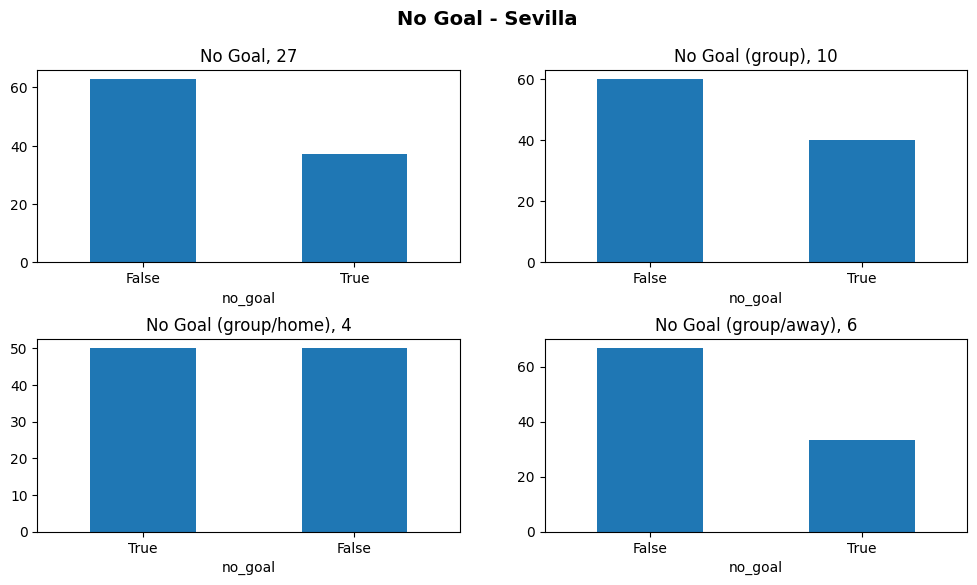

In [147]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"No Goal - {home_team}", fontsize=14, fontweight='bold')

(team_home_df.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal, {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

In [148]:
team_home_df_grp.reset_index()\
                [['main_team','opponent_team','goal_fatti','goal_subiti','giornata','type']]\
                .sort_values('giornata')

,main_team,opponent_team,goal_fatti,goal_subiti,giornata,type
7,Sevilla,Osasuna,1,2,1.0,away
5,Sevilla,Mallorca,1,0,9.0,away
0,Sevilla,Vallecano,0,1,12.0,home
8,Sevilla,Celta,1,1,15.0,away
2,Sevilla,Getafe,2,1,16.0,home
9,Sevilla,Girona,1,2,17.0,away
4,Sevilla,Mallorca,2,0,22.0,home
1,Sevilla,Vallecano,1,1,23.0,away
6,Sevilla,Osasuna,2,3,24.0,home
3,Sevilla,Getafe,0,2,27.0,away


##### N° Goals

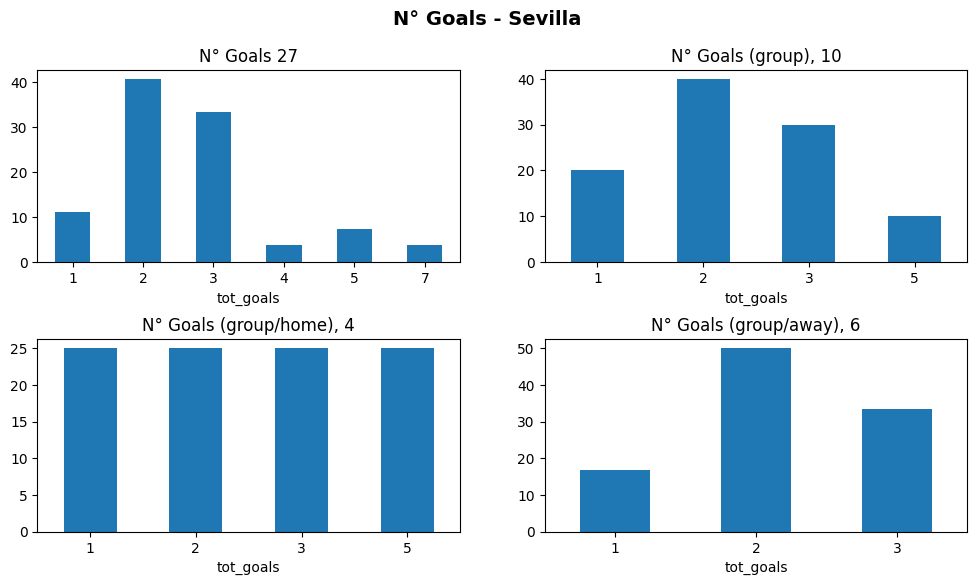

In [149]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"N° Goals - {home_team}", fontsize=14, fontweight='bold')

(team_home_df['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Has scored

<Axes: title={'center': 'Has scored (gpr/away), 6'}, xlabel='team_has_scored'>

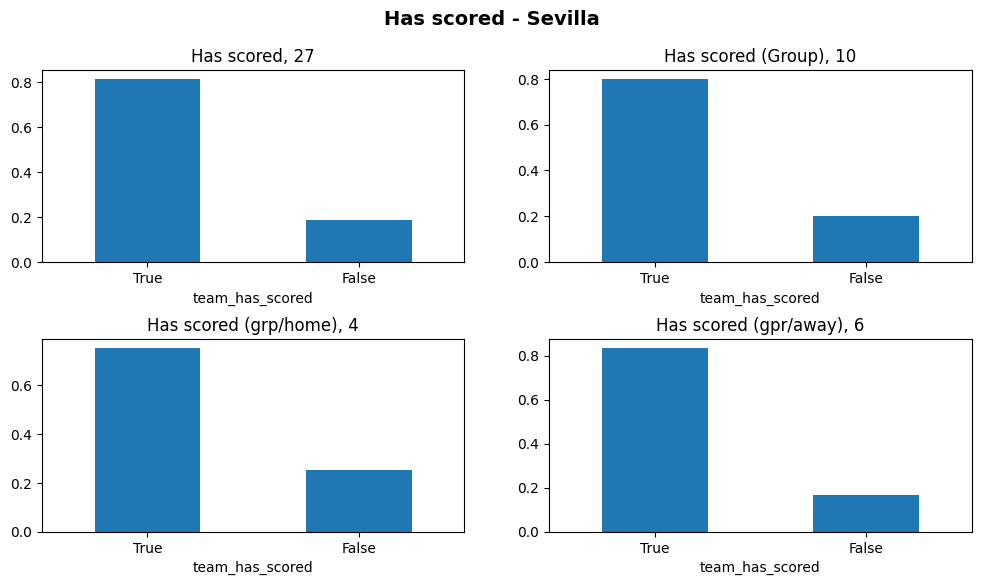

In [150]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Has scored - {home_team}", fontsize=14, fontweight='bold')

team_home_df.team_has_scored.value_counts(normalize=True).plot(kind='bar', rot=0, title=f'Has scored, {len(team_home_df)}', ax=axes[0][0])
team_home_df_grp.team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', rot=0, title=f'Has scored (Group), {len(team_home_df_grp)}', ax=axes[0][1])
team_home_df_grp[team_home_df_grp.type=='home'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', rot=0, title=f'Has scored (grp/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0])
team_home_df_grp[team_home_df_grp.type=='away'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', rot=0, title=f'Has scored (gpr/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1])


In [151]:
team_home_df_grp.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
7,Sevilla,Vallecano,0,True,False,1,1,home,Loss,False,...,"D,D,L,D,L",9,10,8,37,32,31,1,Vallecano,1
8,Sevilla,Vallecano,1,False,True,2,1,away,Draw,True,...,"D,D,L,D,L",9,10,8,37,32,31,1,Vallecano,1
10,Sevilla,Getafe,2,False,True,3,1,home,Win,True,...,"D,W,D,W,L",7,9,11,30,27,34,-7,Getafe,1
11,Sevilla,Getafe,0,True,False,2,2,away,Loss,False,...,"D,W,D,W,L",7,9,11,30,27,34,-7,Getafe,1
15,Sevilla,Mallorca,2,True,False,2,0,home,Win,True,...,"D,L,D,L,L",9,6,12,33,22,27,-5,Mallorca,1


##### Has conceded goal

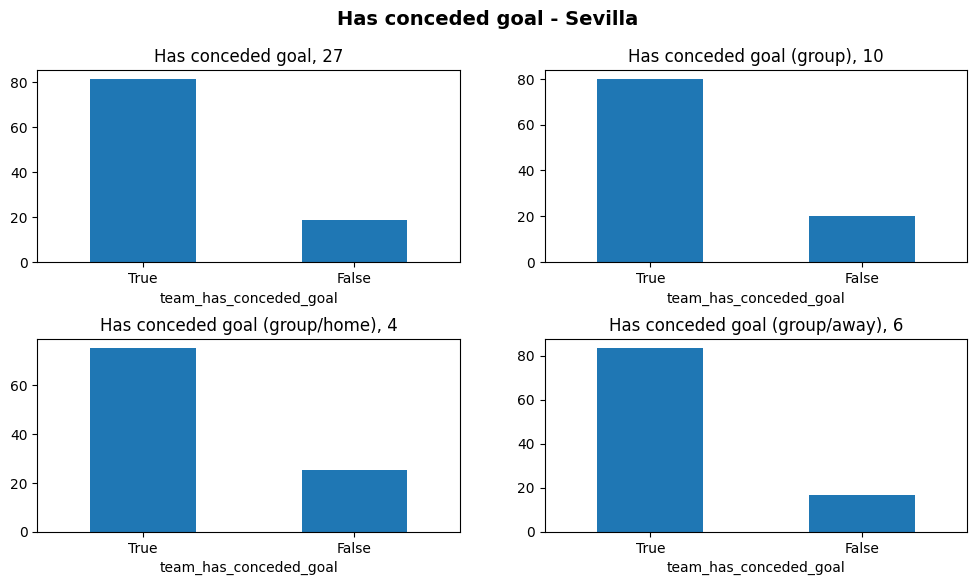

In [152]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Has conceded goal - {home_team}", fontsize=14, fontweight='bold')

(team_home_df.team_has_conceded_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Has conceded goal, {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp.team_has_conceded_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Has conceded goal (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home'].team_has_conceded_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Has conceded goal (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away'].team_has_conceded_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Has conceded goal (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Results

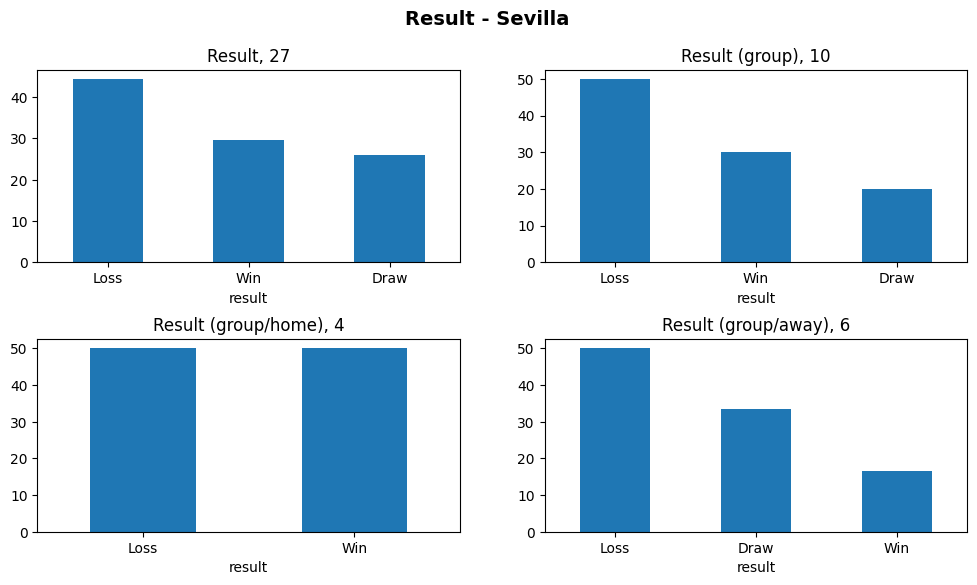

In [153]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Result - {home_team}", fontsize=14, fontweight='bold')

(team_home_df.result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result, {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp.result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home'].result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away'].result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

In [154]:
team_home_df_grp.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
7,Sevilla,Vallecano,0,True,False,1,1,home,Loss,False,...,"D,D,L,D,L",9,10,8,37,32,31,1,Vallecano,1
8,Sevilla,Vallecano,1,False,True,2,1,away,Draw,True,...,"D,D,L,D,L",9,10,8,37,32,31,1,Vallecano,1
10,Sevilla,Getafe,2,False,True,3,1,home,Win,True,...,"D,W,D,W,L",7,9,11,30,27,34,-7,Getafe,1
11,Sevilla,Getafe,0,True,False,2,2,away,Loss,False,...,"D,W,D,W,L",7,9,11,30,27,34,-7,Getafe,1
15,Sevilla,Mallorca,2,True,False,2,0,home,Win,True,...,"D,L,D,L,L",9,6,12,33,22,27,-5,Mallorca,1


##### Result Trend

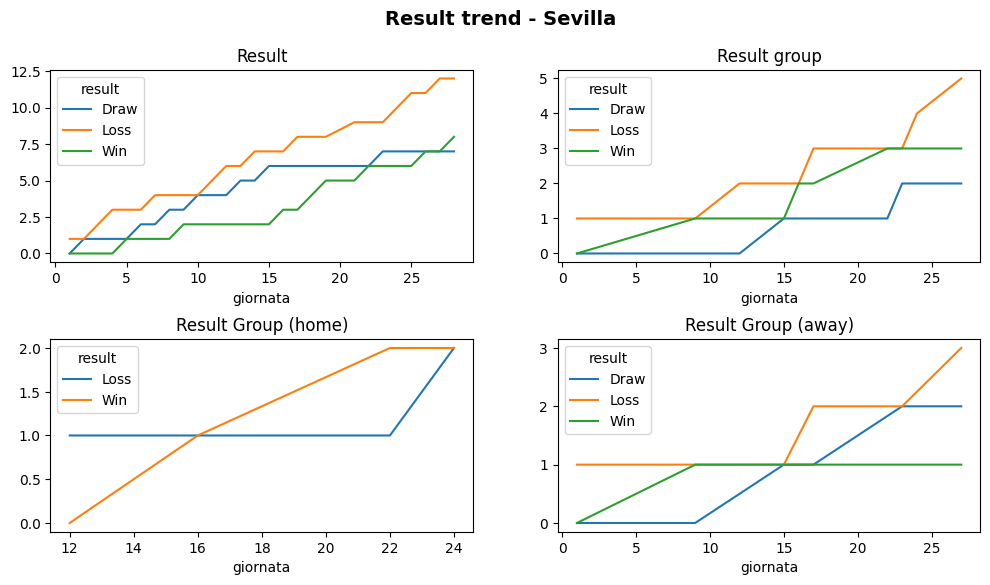

In [155]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Result trend - {home_team}", fontsize=14, fontweight='bold')

team_home_df_grp['value'] = 1
team_home_df['value'] = 1
team_home_df[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result", ax=axes[0][0], rot=0)
team_home_df_grp[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result group", ax=axes[0][1], rot=0)
team_home_df_grp[team_home_df_grp.type=='home'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (home)", ax=axes[1][0], rot=0)
team_home_df_grp[team_home_df_grp.type=='away'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (away)", ax=axes[1][1], rot=0)
plt.show()

#### Away Team

In [156]:
team_away_df = df_match[(df_match.main_team==away_team)]
team_away_df.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal
1,Celta,Espanol,2,False,True,4,2,home,Draw,True,1.0,Goal,True
14,Celta,Real Madrid,1,False,True,5,4,home,Loss,True,2.0,Goal,True
30,Celta,Cadiz,3,True,False,3,0,home,Win,True,4.0,No Goal,False
66,Celta,Betis,1,True,False,1,0,home,Win,True,7.0,No Goal,False
85,Celta,Sociedad,1,False,True,3,2,home,Loss,True,9.0,Goal,True


In [157]:
team_away_df_grp = team_away_df.merge(standing, left_on='opponent_team', right_on='team_short_name')
team_away_df_grp = team_away_df_grp[team_away_df_grp.team_group == standing[standing['team_short_name']==home_team].team_group.max()]

##### Goal/No Goal

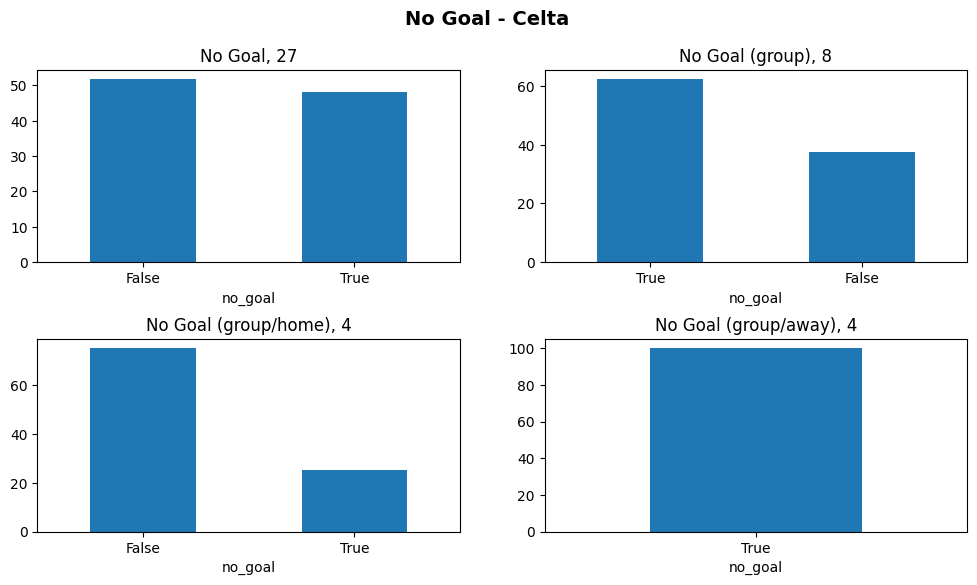

In [158]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"No Goal - {away_team}", fontsize=14, fontweight='bold')

(team_away_df.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal, {len(team_away_df)}', ax=axes[0][0], rot=0)
(team_away_df_grp.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
(team_away_df_grp[team_away_df_grp.type=='home'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_away_df_grp[team_away_df_grp.type=='away'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

In [172]:
team_away_df_grp[team_away_df_grp.type=='away']\
    .reset_index()\
    [['main_team','opponent_team','goal_fatti','goal_subiti', 'giornata','type']].sort_values('giornata')

,main_team,opponent_team,goal_fatti,goal_subiti,giornata,type
2,Celta,Girona,1,0,3.0,away
1,Celta,Vallecano,0,0,14.0,away
3,Celta,Mallorca,0,1,18.0,away
0,Celta,Osasuna,0,0,25.0,away


##### N° Goals

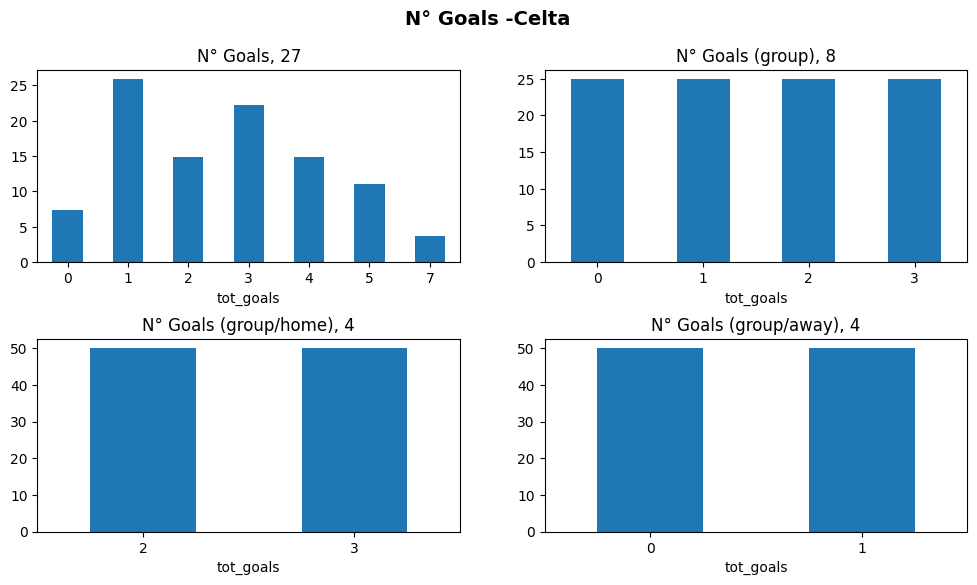

In [160]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"N° Goals -{away_team}", fontsize=14, fontweight='bold')

(team_away_df['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals, {len(team_away_df)}', ax=axes[0][0], rot=0)
(team_away_df_grp['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
(team_away_df_grp[team_away_df_grp.type=='home']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_away_df_grp[team_away_df_grp.type=='away']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Has Scored

<Axes: title={'center': 'Has scored (grp/away), 4'}, xlabel='team_has_scored'>

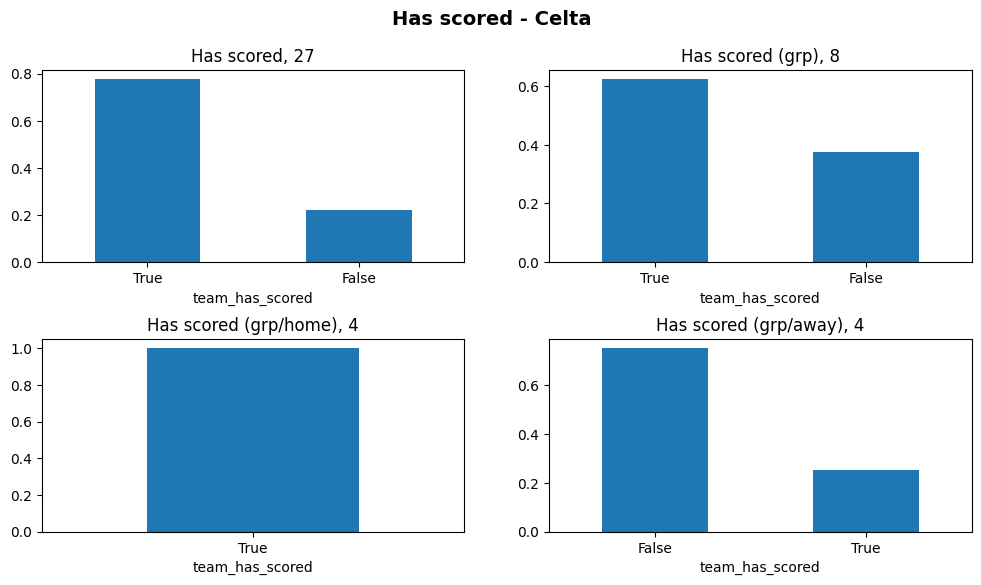

In [161]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Has scored - {away_team}", fontsize=14, fontweight='bold')

team_away_df.team_has_scored.value_counts(normalize=True).plot(kind='bar', title=f'Has scored, {len(team_away_df)}', ax=axes[0][0], rot=0)
team_away_df_grp.team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has scored (grp), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
team_away_df_grp[team_away_df_grp.type=='home'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has scored (grp/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
team_away_df_grp[team_away_df_grp.type=='away'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has scored (grp/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)


##### Has Conceded Goal

<Axes: title={'center': 'Has conceded goal (grp/away), 4'}, xlabel='team_has_conceded_goal'>

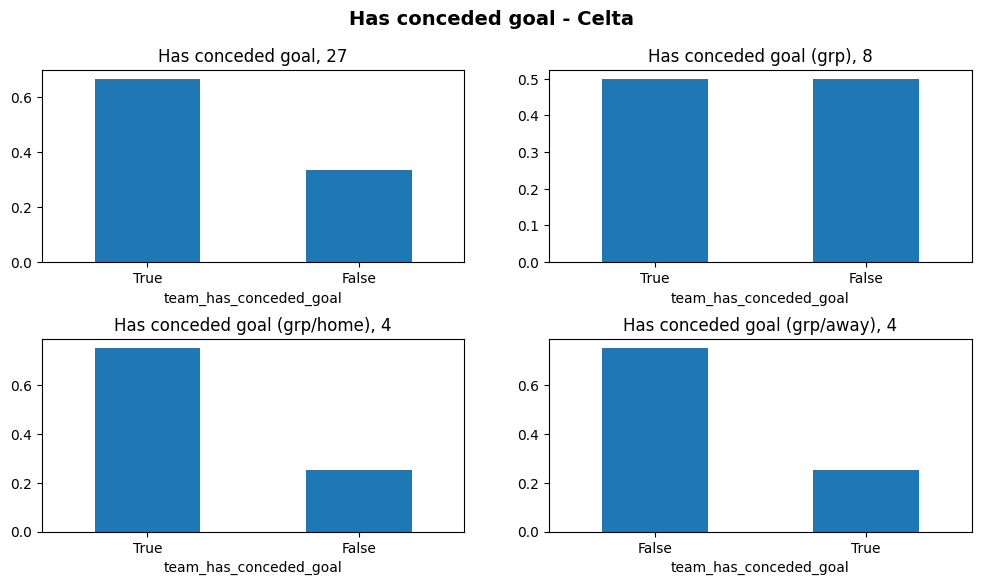

In [162]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Has conceded goal - {away_team}", fontsize=14, fontweight='bold')

team_away_df.team_has_conceded_goal.value_counts(normalize=True).plot(kind='bar', title=f'Has conceded goal, {len(team_away_df)}', ax=axes[0][0], rot=0)
team_away_df_grp.team_has_conceded_goal.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has conceded goal (grp), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
team_away_df_grp[team_away_df_grp.type=='home'].team_has_conceded_goal.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has conceded goal (grp/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
team_away_df_grp[team_away_df_grp.type=='away'].team_has_conceded_goal.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has conceded goal (grp/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)


##### Result

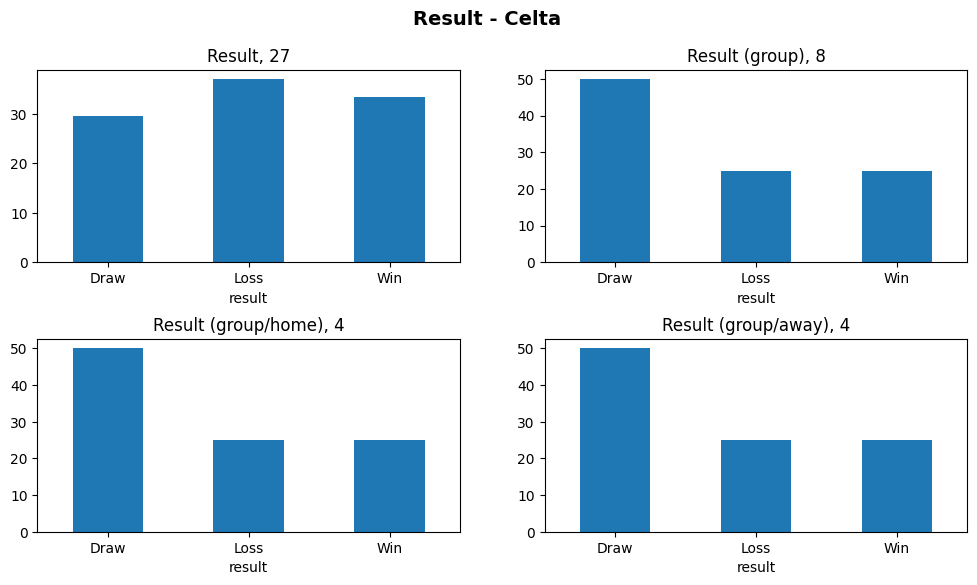

In [163]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Result - {away_team}", fontsize=14, fontweight='bold')

(team_away_df['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result, {len(team_away_df)}', ax=axes[0][0], rot=0)
(team_away_df_grp['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result (group), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
(team_away_df_grp[team_away_df_grp.type=='home']['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result (group/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_away_df_grp[team_away_df_grp.type=='away']['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result (group/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Result Trend

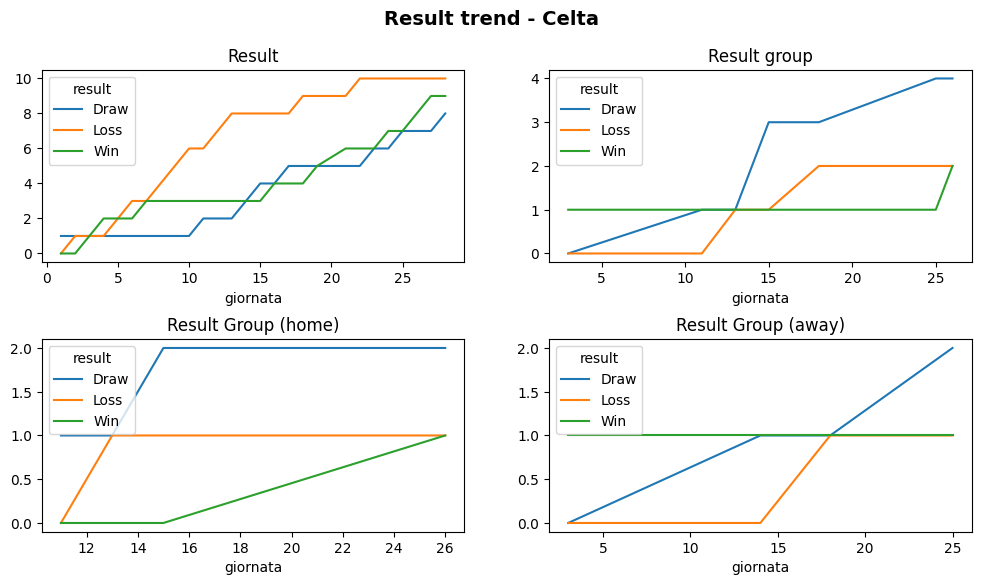

In [164]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Result trend - {away_team}", fontsize=14, fontweight='bold')

team_away_df_grp['value'] = 1
team_away_df['value'] = 1
team_away_df[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result", ax=axes[0][0], rot=0)
team_away_df_grp[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result group", ax=axes[0][1], rot=0)
team_away_df_grp[team_away_df_grp.type=='home'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (home)", ax=axes[1][0], rot=0)
team_away_df_grp[team_away_df_grp.type=='away'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (away)", ax=axes[1][1], rot=0)
plt.show()

## Analysis

### Plot number goals over giornate

In [ ]:
df[['giornata','tot_goals']].groupby(['giornata']).sum().tot_goals.plot()

### Goals distribution over matches in each giornata

In [ ]:
df['row_num'] = df.groupby('giornata').cumcount()
boxgoals = df[['giornata','row_num','tot_goals']].pivot(index='row_num', columns='giornata', values='tot_goals')

In [ ]:
boxgoals.plot(kind='box', figsize=(12,4))

### Under/Over

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
df_match[['main_team', 'tot_goals']].groupby('main_team').mean().sort_values('tot_goals').plot(kind='bar',  ax=ax[0])
df_match[df_match.type=='home'][['main_team', 'tot_goals']].groupby('main_team').mean().sort_values('tot_goals').plot(kind='bar',  ax=ax[1])
df_match[df_match.type=='away'][['main_team', 'tot_goals']].groupby('main_team').mean().sort_values('tot_goals').plot(kind='bar',  ax=ax[2])

ax[0].set_title('Total')
ax[1].set_title('Home')
ax[2].set_title('Away')
ax[0].set_ylabel('Average goals')
ax[1].set_ylabel('Average goals')
ax[2].set_ylabel('Average goals')

plt.show()

### Goal/No Goal

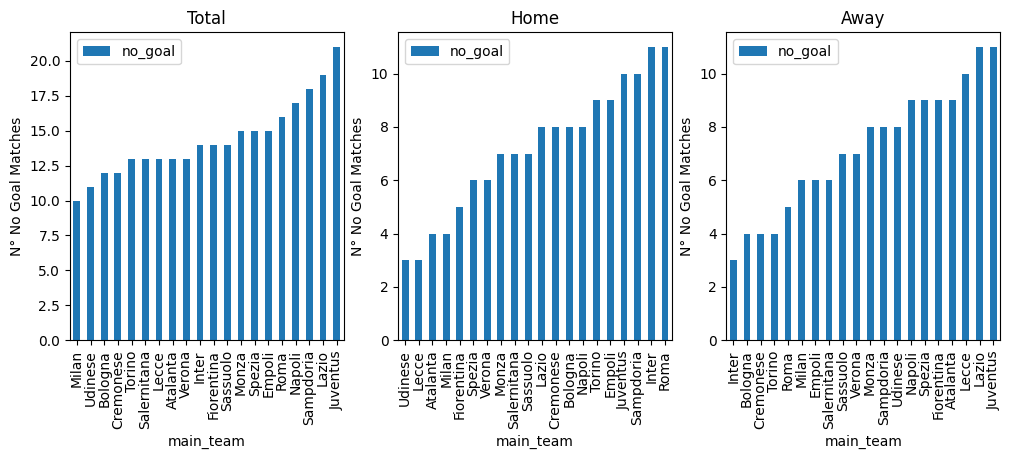

In [466]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
df_match[['main_team','no_goal']].groupby('main_team').sum().sort_values('no_goal').plot(kind='bar',  ax=ax[0])
df_match[df_match.type=='home'][['main_team','no_goal']].groupby('main_team').sum().sort_values('no_goal').plot(kind='bar',  ax=ax[1])
df_match[df_match.type=='away'][['main_team','no_goal']].groupby('main_team').sum().sort_values('no_goal').plot(kind='bar',  ax=ax[2])

ax[0].set_title('Total')
ax[1].set_title('Home')
ax[2].set_title('Away')
ax[0].set_ylabel('N° No Goal Matches')
ax[1].set_ylabel('N° No Goal Matches')
ax[2].set_ylabel('N° No Goal Matches')

plt.show()

In [467]:
df_match[(df_match.main_team == 'Real Madrid') & (df_match.type=='home')]

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal


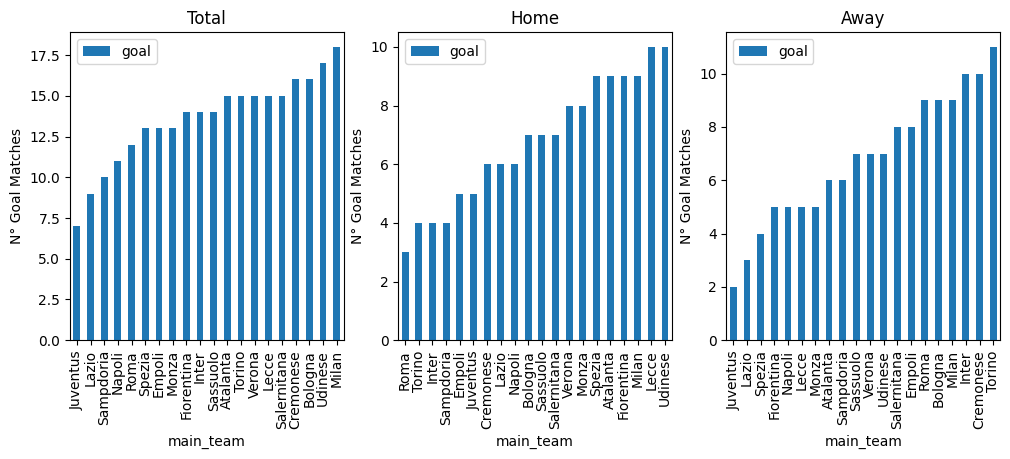

In [468]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
df_match[['main_team','goal']].groupby('main_team').sum().sort_values('goal').plot(kind='bar',  ax=ax[0])
df_match[df_match.type=='home'][['main_team','goal']].groupby('main_team').sum().sort_values('goal').plot(kind='bar',  ax=ax[1])
df_match[df_match.type=='away'][['main_team','goal']].groupby('main_team').sum().sort_values('goal').plot(kind='bar',  ax=ax[2])

ax[0].set_title('Total')
ax[1].set_title('Home')
ax[2].set_title('Away')
ax[0].set_ylabel('N° Goal Matches')
ax[1].set_ylabel('N° Goal Matches')
ax[2].set_ylabel('N° Goal Matches')

plt.show()